In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/taiger/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import datagen
import utils
from model import RPN

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


(array([9, 9]), array([[ 0.48430493,  0.6995516 ,  0.5515695 ,  0.84753364],
        [ 0.7040359 ,  0.58295965,  0.84753364,  0.7264574 ],
        [-0.00448431, -0.00448431, -0.00896861, -0.00896861],
        [-0.00448431, -0.00448431, -0.00896861, -0.00896861]],
       dtype=float32))

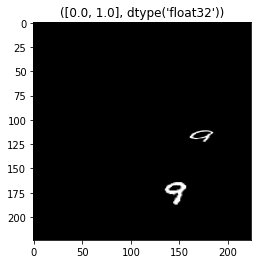

In [3]:
images, gt_cls, gt_boxes = datagen.generate_batch(1)
_max = int(np.max(images))

image = images[0].copy()
plt.title((np.percentile(image, [0, 100]).tolist(), image.dtype))
plt.imshow(image, cmap='gray')

gt_cls[0], gt_boxes[0]

In [4]:
tf.reset_default_graph()
model = RPN()
sess = tf.Session()
sess.run(tf.global_variables_initializer())

feed_dict = {
    model.images: images,
    model.gt_boxes: gt_boxes,
}

In [5]:
anchors, labels, mappings, bboxes = sess.run(model.test, feed_dict)
anchors.shape, labels.shape, mappings.shape, bboxes.shape

((49980, 4), (49980,), (49980,), (49980, 4))

In [6]:
anchors = utils.denorm_boxes(anchors, [RPN.h, RPN.w])
bboxes = utils.denorm_boxes(bboxes, [RPN.h, RPN.w])

In [7]:
print('labels  ', np.unique(labels, return_counts=True), sep='\t')
print('mappings', np.unique(mappings, return_counts=True), sep='\t')

labels  	(array([-1.,  0.,  1.], dtype=float32), array([47212,  2759,     9]))
mappings	(array([0, 1]), array([46040,  3940]))


## Positive anchors

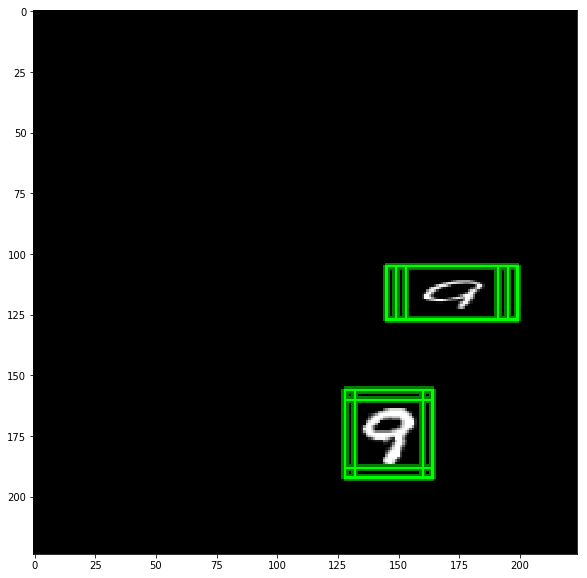

In [8]:
viz = image.copy()

pos = labels == 1
for mapping, (y1, x1, y2, x2) in zip(mappings[pos], anchors[pos]):
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, _max * 0.5, 0), 2)
    
for mapping, (y1, x1, y2, x2) in zip(mappings[pos], bboxes[pos]):
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, _max, 0), 1)
    
plt.figure(figsize=(10, 10))
plt.imshow(viz);

## Negative anchors

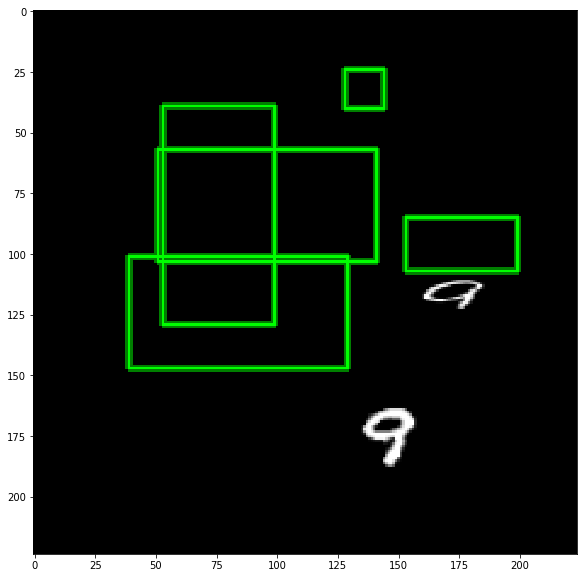

In [9]:
viz = image.copy()

neg = np.random.choice(np.where(labels == -1)[0], size=[5])
for mapping, (y1, x1, y2, x2) in zip(mappings[neg], anchors[neg]):
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, _max * 0.5, 0), 2)
    
for mapping, (y1, x1, y2, x2) in zip(mappings[neg], bboxes[neg]):
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, _max, 0), 1)
    
plt.figure(figsize=(10, 10))
plt.imshow(viz);

### Neutral anchors

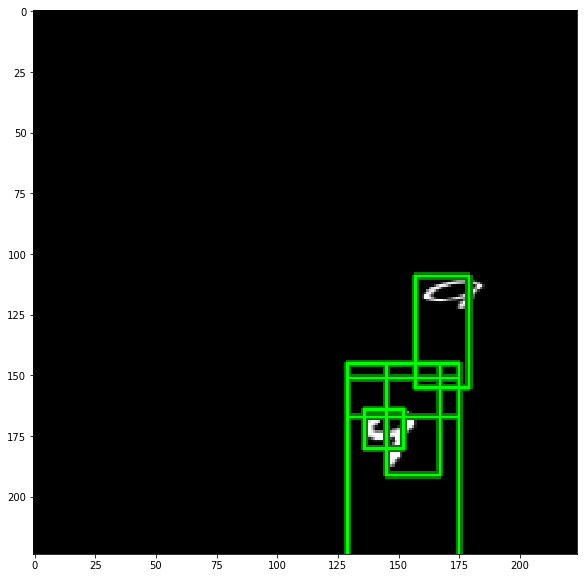

In [10]:
viz = image.copy()
neg = np.random.choice(np.where(labels == 0)[0], size=[5])
for mapping, (y1, x1, y2, x2) in zip(mappings[neg], anchors[neg]):
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, _max * 0.5, 0), 2)
    
for mapping, (y1, x1, y2, x2) in zip(mappings[neg], bboxes[neg]):
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, _max, 0), 1)
    
plt.figure(figsize=(10, 10))
plt.imshow(viz);

## Loss functions

In [11]:
rpn_bboxes = bboxes[labels == 1]
rpn_bboxes.shape

(9, 4)

In [12]:
target_bboxes = gt_boxes[0][mappings][labels == 1]
target_bboxes = utils.denorm_boxes(target_bboxes, [RPN.h, RPN.w])
target_bboxes.shape

(9, 4)

### Ensure correct mapping

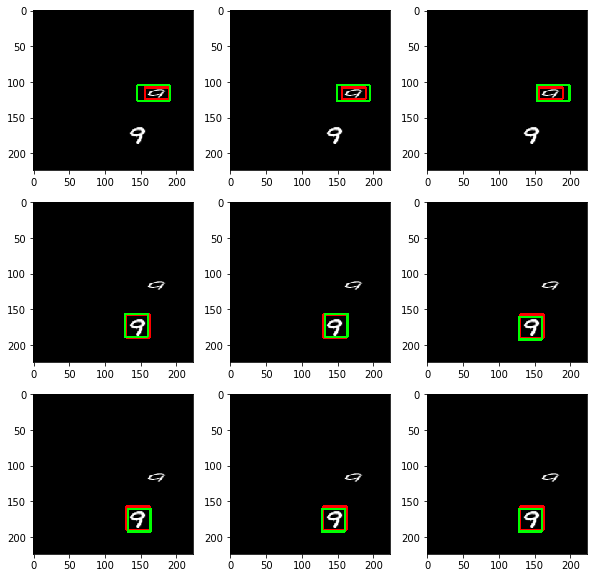

In [13]:
plt.figure(figsize=(10, 10))
for i in range(len(target_bboxes)):
    plt.subplot(3, 3, i+1)
    viz = image.copy()
    y1, x1, y2, x2 = target_bboxes[i]
    cv2.rectangle(viz, (x1, y1), (x2, y2), (_max, 0, 0), 2)
    y1, x1, y2, x2 = rpn_bboxes[i]
    cv2.rectangle(viz, (x1, y1), (x2, y2), (0, _max, 0), 2)
    plt.imshow(viz)

In [14]:
target_bboxes = utils.norm_boxes(target_bboxes, [RPN.h, RPN.w])
rpn_bboxes = utils.norm_boxes(rpn_bboxes, [RPN.h, RPN.w])
np.mean(np.abs(target_bboxes - rpn_bboxes))

0.013203779

In [15]:
sess.run(model.bbox_loss, feed_dict)  # discrepancy due to top-k subsampling

0.028399605